# Topic extraction

Using `tomotopy`'s PAM implementation.
Comparing different number of topics and evaluating coherence.

In [14]:
%load_ext autotime

import psycopg2
import numpy 
import nltk
import wordcloud
import matplotlib.pyplot as plt
import gensim
from tqdm import tqdm
import multiprocessing
import tomotopy as tp

DATASET_NAME = '20k-lemma-nophrase'
MODEL_CLASS = 'MGLDAModel'
TOPIC_COUNTS = list(range(2,50))
N_REPEATS = 3
CONSTANT_PARAMS = {
    'tw': tp.TermWeight.ONE,
}

# DATASET_NAME = 'small'
# MODEL_CLASS = 'PAModel'
# TOPIC_COUNTS = list(reversed(range(2,6)))
# N_REPEATS = 2
# CONSTANT_PARAMS = {
#     'tw': tp.TermWeight.ONE,
# }


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.9 ms


In [15]:
def log(message):
    print(message, flush=True)

time: 564 µs


In [16]:
import pickle

log('Loading dataset...')
dataset = pickle.load(open(f'dataset.{DATASET_NAME}.pkl', 'rb'))
data_train = dataset['train']
data_test  = dataset['test']

print("Building gensim corpus...")
gensim_dictionary = gensim.corpora.Dictionary(data_train)

log(f'{len(data_train)} training documents')
log(f'{len(data_test)} test documents')

Loading dataset...
Building gensim corpus...
14516 training documents
3629 test documents
time: 625 ms


In [17]:
import tomotopy as tp
from tqdm import tqdm

print('Prepping corpus...')
corpus_train = tp.utils.Corpus()
for doc in tqdm(data_train):
    corpus_train.add_doc(doc)

 23%|██▎       | 3282/14516 [00:00<00:00, 20926.82it/s]

Prepping corpus...


100%|██████████| 14516/14516 [00:00<00:00, 54765.66it/s]

time: 273 ms


In [18]:
import metadata as md

# TODO: find or create model
def prepare_model(**params):
    k = params.pop('k')

    for meta in md.session.query(md.Model).filter_by(klass=MODEL_CLASS, dataset=DATASET_NAME, k=k).all():
        if meta.params == params:
            return (None, meta)
        
    model = getattr(tp, MODEL_CLASS)(
        corpus=corpus_train,
        k=k,
#         k2=k,
#         k1=k//4 + 1,
        **params)
    
    meta = md.Model(
        dataset=DATASET_NAME,
        klass=MODEL_CLASS,
        k=k,
        params=params)
    
    return (model, meta)

time: 2.69 ms


In [19]:
import helpers as h

inputs = [(k,seed) for k in TOPIC_COUNTS for seed in range(N_REPEATS)]

log('Evaluating models...')
for k,seed in tqdm(inputs):
    m, meta = prepare_model(k=k, seed=seed, **CONSTANT_PARAMS)
    if m is None:
        print('skipping for k=%d, seed=%d' % (k,seed))
        continue
    
    t,n = h.train_model(m)
    
    meta.iterations = n
    meta.duration = t
    meta.perplexity = m.perplexity
    
    topic_words = h.get_topic_words(m)
    cv = h.eval_coherence(topic_words, gensim_dictionary, data_train, coherence_type='c_v')
    meta.c_v = cv
    
    cu = h.eval_coherence(topic_words, gensim_dictionary, data_train, coherence_type='u_mass')    
    meta.c_umass = cu

    cnpmi = h.eval_coherence(topic_words, gensim_dictionary, data_train, coherence_type='c_npmi')    
    meta.c_npmi = cnpmi

    m.save(meta.path, full=False)
    md.session.add(meta)
    md.session.commit()

Evaluating models...


  0%|          | 0/144 [00:00<?, ?it/s]


TypeError: 'k' is an invalid keyword argument for this function

time: 148 ms


In [7]:
import collections
import numpy as np

# returns x, y, sigma
def prep_metric(metas, field):
    d = collections.defaultdict(list)
    for m in metas:
        d[m.k].append(m.__getattribute__(field))
    
    x = []
    y = []
    s = []
    for k in sorted(d.keys()):
        a = np.array(d[k])
        x.append(k)
        y.append(np.average(a))
        s.append(np.std(a))

#         med = np.median(a)
#         mad = np.median(np.abs(a - med))
#         y.append(med)
#         s.append(mad)
    
    return (
        np.array(x),
        np.array(y),
        np.array(s),
    )

time: 1.36 ms


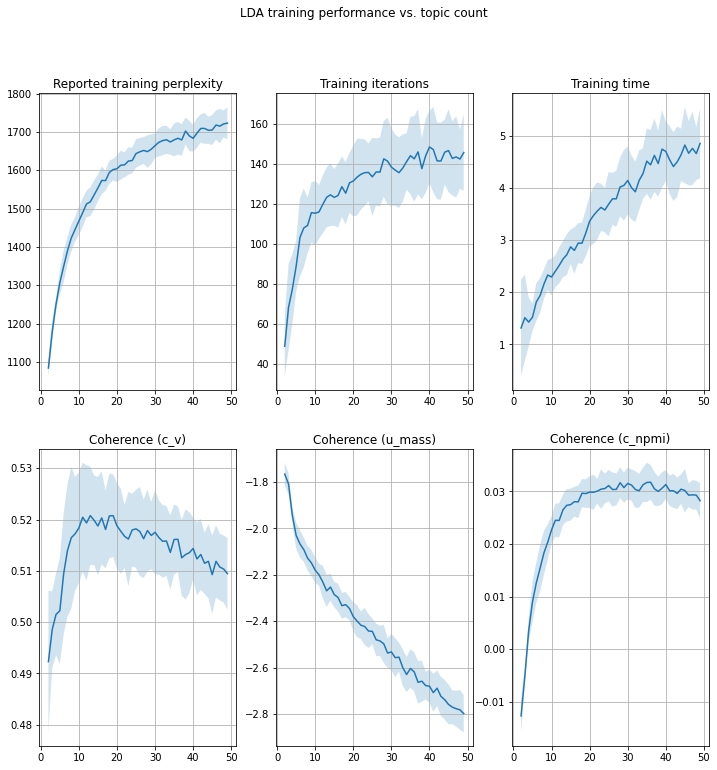

time: 872 ms


In [12]:
import metadata as md
import sqlalchemy as sql
import sqlalchemy.sql.expression as expr

metas = []
for meta in md.session.query(md.Model).filter(
    expr.and_(
        md.Model.dataset == DATASET_NAME,
        md.Model.klass == MODEL_CLASS,
        md.Model.k.in_(list(TOPIC_COUNTS))
    )).all():
    p = meta.params.copy()
    p.update(CONSTANT_PARAMS)
    if p != meta.params: continue
    metas.append(meta)


fig = plt.figure(figsize=(12,12))
fig.suptitle('LDA training performance vs. topic count')


x,y,s = prep_metric(metas, 'perplexity')

plt.subplot(231)
plt.plot(x,y)
plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Reported training perplexity')


x,y,s = prep_metric(metas, 'iterations')

plt.subplot(232)
plt.plot(x,y)
plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Training iterations')


x,y,s = prep_metric(metas, 'duration')

plt.subplot(233)
plt.plot(x,y)
plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Training time')


x,y,s = prep_metric(metas, 'c_v')

plt.subplot(234)
plt.plot(x,y)
plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Coherence (c_v)')


x,y,s = prep_metric(metas, 'c_umass')

plt.subplot(235)
plt.plot(x,y)
plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Coherence (u_mass)')


x,y,s = prep_metric(metas, 'c_npmi')

plt.subplot(236)
plt.plot(x,y)
plt.fill_between(x, y-s, y+s, alpha=0.2)
plt.grid()
plt.title('Coherence (c_npmi)')

plt.show()



In [13]:
m = max(metas, key=lambda m: m.c_v)
print('Best model for c_v: k=%d c_v=%.3f' % (m.k, m.c_v))

m = max(metas, key=lambda m: m.c_npmi)
print('Best model for c_npmi: k=%d' % (m.k))

Best model for c_v: k=8 c_v=0.546
Best model for c_npmi: k=45
time: 5.03 ms
